In [67]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
path = '../astrometry_solutions/Luminance/RV_UMa_2022_03_20.fits'
f = fits.open(path)
w = WCS(f[0].header)


In [68]:
import ccdproc as ccdp
data = f[0].data
f.close()

In [69]:
import pandas as pd
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict

In [70]:
positions = pd.DataFrame([excluding_duplicates(image_trimmer(find_sources(data), data), 9)['xcentroid'], excluding_duplicates(image_trimmer(find_sources(data), data), 9)['ycentroid']]).T

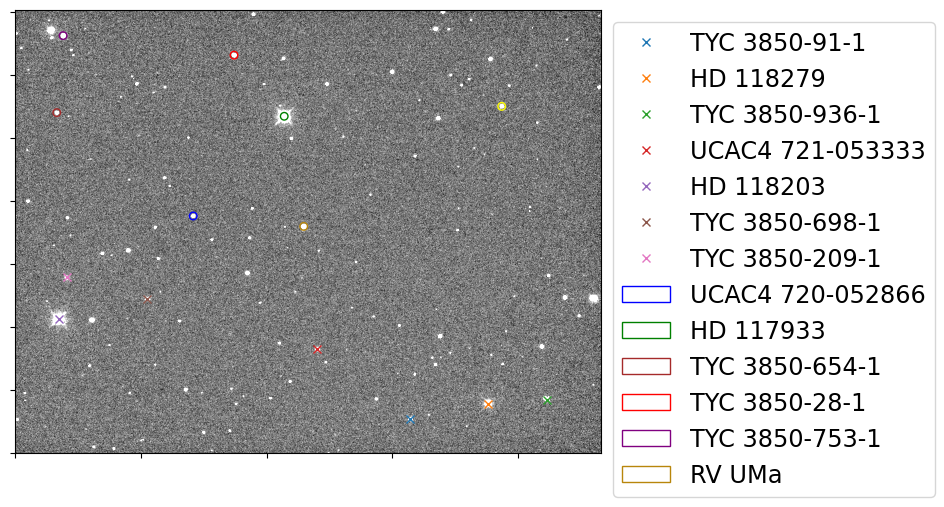

In [76]:
from convenience_functions import show_image
import matplotlib.pyplot as plt
plt.style.use('guide.mplstyle')
show_image(data, cmap = 'gray', show_colorbar=False, show_ticks= False)
plt.plot(positions.iloc[2]['xcentroid'], positions.iloc[2]['ycentroid'], 'x', label = 'TYC 3850-91-1')
plt.plot(positions.iloc[5]['xcentroid'], positions.iloc[5]['ycentroid'], 'x', label = 'HD 118279')
plt.plot(positions.iloc[6]['xcentroid'], positions.iloc[6]['ycentroid'], 'x', label = 'TYC 3850-936-1')
plt.plot(positions.iloc[10]['xcentroid'], positions.iloc[10]['ycentroid'], 'x', label = 'UCAC4 721-053333')
plt.plot(positions.iloc[13]['xcentroid'], positions.iloc[13]['ycentroid'], 'x', label = 'HD 118203')
plt.plot(positions.iloc[14]['xcentroid'], positions.iloc[14]['ycentroid'], 'x', label = 'TYC 3850-698-1')
plt.plot(positions.iloc[15]['xcentroid'], positions.iloc[15]['ycentroid'], 'x', label = 'TYC 3850-209-1')
circle1 = plt.Circle((positions.iloc[23]['xcentroid'], positions.iloc[23]['ycentroid']), 30, color = 'b', fill=False, label = 'UCAC4 720-052866')
# plt.plot(positions.iloc[23]['xcentroid'], positions.iloc[23]['ycentroid'], 'o', label = 'UCAC4 720-052866')
circle2 = plt.Circle((positions.iloc[28]['xcentroid'], positions.iloc[28]['ycentroid']), 30, color = 'g', fill=False, label = 'HD 117933')
# plt.plot(positions.iloc[28]['xcentroid'], positions.iloc[28]['ycentroid'], 'o', label = 'HD 117933')
circle3 = plt.Circle((positions.iloc[29]['xcentroid'], positions.iloc[29]['ycentroid']), 30, color = 'brown', fill=False,  label = 'TYC 3850-654-1')
# plt.plot(positions.iloc[29]['xcentroid'], positions.iloc[29]['ycentroid'], 'o', label = 'TYC 3850-654-1')
circle4 = plt.Circle((positions.iloc[30]['xcentroid'], positions.iloc[30]['ycentroid']), 30, color = 'yellow', fill=False)
# plt.plot(positions.iloc[30]['xcentroid'], positions.iloc[30]['ycentroid'], 'o', label = 'TYC 3850-118-1')
circle5 = plt.Circle((positions.iloc[36]['xcentroid'], positions.iloc[36]['ycentroid']), 30, color = 'red', fill=False, label = 'TYC 3850-28-1')
# plt.plot(positions.iloc[36]['xcentroid'], positions.iloc[36]['ycentroid'], 'o', label = 'TYC 3850-28-1')
circle6 = plt.Circle((positions.iloc[38]['xcentroid'], positions.iloc[38]['ycentroid']), 30, color = 'purple', fill=False, label = 'TYC 3850-753-1')
# plt.plot(positions.iloc[38]['xcentroid'], positions.iloc[38]['ycentroid'], 'o', label = 'TYC 3850-753-1')
circle7 = plt.Circle((positions.iloc[22]['xcentroid'], positions.iloc[22]['ycentroid']), 30, color = 'darkgoldenrod', fill=False, label = 'RV UMa')
# plt.plot(positions.iloc[22]['xcentroid'], positions.iloc[22]['ycentroid'], 'o', label = 'RV UMa')

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)
plt.gca().add_patch(circle5)
plt.gca().add_patch(circle6)
plt.gca().add_patch(circle7)

plt.legend(bbox_to_anchor = (1,1))
plt.savefig('./Images/Sources_20th_March.png', bbox_inches = 'tight');

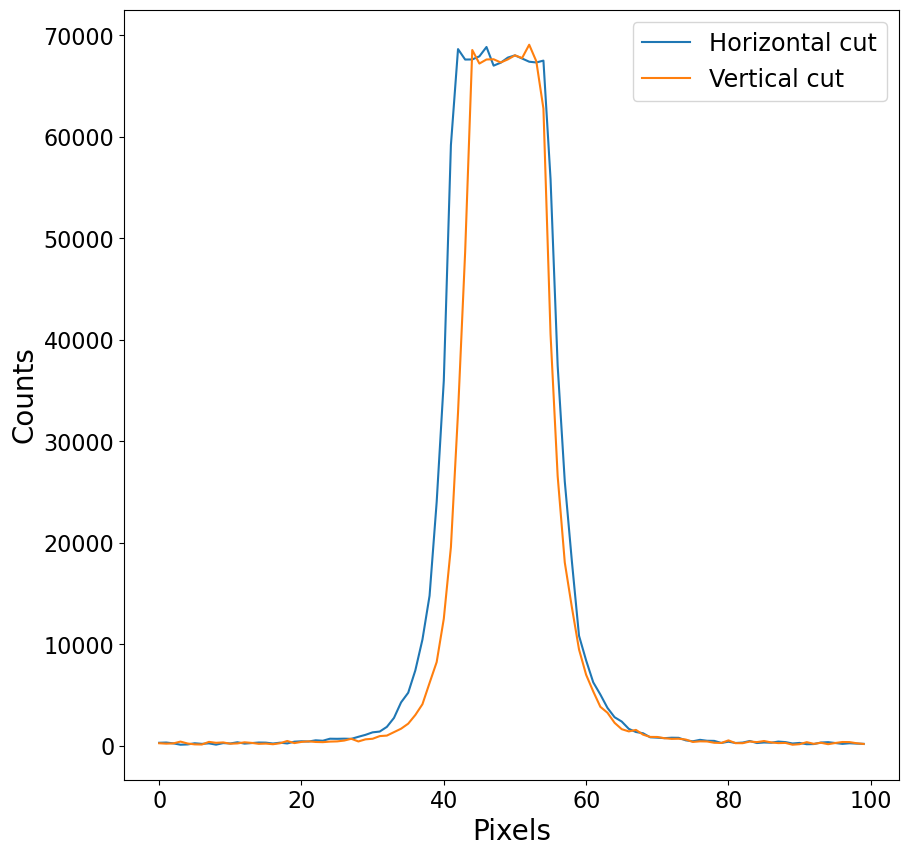

In [75]:
x, y = positions.iloc[13]['xcentroid'], positions.iloc[13]['ycentroid']

plt.plot(data[np.floor(y).astype(int)][np.floor(x).astype(int) - 50 : np.floor(x).astype(int)+50], label = 'Horizontal cut')
plt.plot(data.T[np.floor(x).astype(int)][np.floor(y).astype(int) - 50 : np.floor(y).astype(int)+50], label = 'Vertical cut')
plt.legend()
plt.xlabel('Pixels')
plt.ylabel('Counts')
plt.savefig('./Images/line_profile_saturated_star.png')

# Finding the galaxy

In [73]:
import pandas as pd
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict

In [74]:
sources_22 = excluding_duplicates(image_trimmer(find_sources(data_22), data_22), 9)

NameError: name 'data_22' is not defined

In [ ]:
sources_22

In [ ]:
for index, x, y in zip(sources_22.index, sources_22['xcentroid'], sources_22['ycentroid']):
    print(index, w.pixel_to_world(x, y))

# Reading the data

In [ ]:


star_data = pd.read_csv('star.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_data = pd.read_csv('galaxy.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_x_axis = np.arange(8, 8+len(galaxy_data), 1)

plt.plot(star_data, color = 'red', label = 'Star')
plt.plot(galaxy_x_axis, galaxy_data, color = 'blue', label = 'Galaxy')
plt.legend()